<a href="https://colab.research.google.com/github/diegopueyo/THESIS1/blob/main/THESIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# CELL 1: Imports and Google Drive mounting
# -----------------------------------------------------------------------------

!pip install tqdm

import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from google.colab import drive
import os
import pickle
from tqdm import tqdm
from collections import Counter
import math
import time
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/THESIS'
os.makedirs(base_path, exist_ok=True)
print(f"Working directory: {base_path}")

Mounted at /content/drive
Working directory: /content/drive/MyDrive/THESIS


In [2]:
 #CELL 2: Dataset Processing and Interaction Labeling
# -----------------------------------------------------------------------------

def process_original_dataset(file_path, max_users=10000, max_items=5000):

    cols = ['user_id','item_id','category_id','behavior_type','timestamp']
    chunk_size = 1_000_000
    user_inter = {}
    item_counts = Counter()

    # Processing in chunks to handle large datasets
    for chunk in tqdm(pd.read_csv(file_path, names=cols, chunksize=chunk_size), desc="Processing chunks"):
        # Labeling according to methodology: positive (1) for cart/favorites/purchase, negative (0) for pv
        chunk['clicked'] = chunk['behavior_type'].map(lambda x: 0 if x=='pv' else 1)

        # Item popularity counting
        for itm, cnt in chunk['item_id'].value_counts().items():
            item_counts[itm] += cnt

        # Store the "strongest" interaction for each (user,item) pair
        for _, r in chunk.iterrows():
            u, i = r['user_id'], r['item_id']
            prev = user_inter.get(u, {}).get(i)
            if (prev is None) or (r['clicked'] > prev['clicked']):
                user_inter.setdefault(u,{})[i] = {
                    'category_id':    r['category_id'],
                    'behavior_type':  r['behavior_type'],
                    'timestamp':      r['timestamp'],
                    'clicked':        r['clicked']
                }

        # User limiter for memory control
        if len(user_inter) >= max_users*2:
            break

    # Filter popular items (top-K)
    popular = set(it for it,_ in item_counts.most_common(max_items))
    rows = []
    for u, items in user_inter.items():
        for i, info in items.items():
            if i in popular:
                rows.append({
                    'user_id':       u,
                    'item_id':       i,
                    'category_id':   info['category_id'],
                    'behavior_type': info['behavior_type'],
                    'timestamp':     info['timestamp'],
                    'clicked':       info['clicked']
                })

    df = pd.DataFrame(rows)

    # Filter most active users
    top_users = df.groupby('user_id').size().nlargest(max_users).index
    return df[df['user_id'].isin(top_users)].reset_index(drop=True)

# Path to the original dataset
DATA_FILE = "/content/drive/MyDrive/THESIS/UserBehavior.csv"
subset_file = f"{base_path}/subset_full.csv"

# Load preprocessed data if exists, or create it
if os.path.exists(subset_file):
    subset = pd.read_csv(subset_file)
    print(f"Data loaded from file: {subset_file}")
else:
    print(f"Processing original dataset: {DATA_FILE}")
    subset = process_original_dataset(DATA_FILE)
    subset.to_csv(subset_file, index=False)

print(f"Final subset: {subset.shape}, columns = {subset.columns.tolist()}")

Data loaded from file: /content/drive/MyDrive/THESIS/subset_full.csv
Final subset: (231600, 6), columns = ['user_id', 'item_id', 'category_id', 'behavior_type', 'timestamp', 'clicked']


In [9]:
# CELL 3: Train-Test Split with Stratified Sampling
# -----------------------------------------------------------------------------

train_file = f"{base_path}/train_full.csv"
test_file = f"{base_path}/test_full.csv"

if os.path.exists(train_file) and os.path.exists(test_file):
    train = pd.read_csv(train_file)
    test = pd.read_csv(test_file)
    print("Training and test data loaded from existing files")
else:
    print("Performing stratified train-test split...")
    # Class balancing: same number of positives and negatives
    pos = subset[subset.clicked==1]
    neg = subset[subset.clicked==0].sample(n=len(pos), random_state=42)
    data = pd.concat([pos,neg]).reset_index(drop=True)

    # Stratified split (80% train, 20% test) maintaining class proportions
    train, test = train_test_split(
        data,
        test_size=0.2,
        stratify=data['clicked'],
        random_state=42
    )

    # Save splits for future runs
    train.to_csv(train_file, index=False)
    test.to_csv(test_file, index=False)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Proportion of positives in train: {train.clicked.mean():.4f}")
print(f"Proportion of positives in test: {test.clicked.mean():.4f}")

Training and test data loaded from existing files
Train shape: (44147, 6)
Test shape: (11037, 6)
Proportion of positives in train: 0.5000
Proportion of positives in test: 0.5000


In [10]:
# CELL 4: User-Item Interaction Matrix Construction
# -----------------------------------------------------------------------------

# ID to index mappings for efficiency
all_users = train.user_id.unique()
all_items = train.item_id.unique()

u2i = {u:idx for idx,u in enumerate(all_users)}
v2i = {v:idx for idx,v in enumerate(all_items)}
i2u = {idx:u for u,idx in u2i.items()}
i2v = {idx:v for v,idx in v2i.items()}

# Save ID mappings
mappings_file = f"{base_path}/id_mappings.pkl"
if not os.path.exists(mappings_file):
    with open(mappings_file, "wb") as f:
        pickle.dump((u2i, v2i, i2u, i2v), f)
    print(f"ID mappings saved to: {mappings_file}")
else:
    print(f"ID mappings file already exists: {mappings_file}")

# Construction of sparse matrix for interactions
rows = train.user_id.map(u2i)
cols = train.item_id.map(v2i)
vals = train.clicked.astype(np.float32)

# Matrix M[u,i] = 1 if user u interacted positively with item i
M = csr_matrix((vals, (rows, cols)), shape=(len(all_users), len(all_items)))

# Save matrix for future use
matrix_file = f"{base_path}/user_item_matrix.pkl"
if not os.path.exists(matrix_file):
    with open(matrix_file, "wb") as f:
        pickle.dump(M, f)
    print(f"Interaction matrix saved to: {matrix_file}")
else:
    with open(matrix_file, "rb") as f:
        M = pickle.load(f)
    print(f"Interaction matrix loaded from: {matrix_file}")

print(f"Interaction matrix M: {M.shape} users×items")
print(f"Matrix density: {M.nnz/(M.shape[0]*M.shape[1]):.6f}")

ID mappings file already exists: /content/drive/MyDrive/THESIS/id_mappings.pkl
Interaction matrix loaded from: /content/drive/MyDrive/THESIS/user_item_matrix.pkl
Interaction matrix M: (9637, 4961) users×items
Matrix density: 0.000923


In [11]:
# CELL 5: Item-Based Collaborative Filtering
# -----------------------------------------------------------------------------

# Calculate item-item cosine similarity
print("Calculating cosine similarity matrix between items...")
item_sim_file = f"{base_path}/item_similarity.npy"

if os.path.exists(item_sim_file):
    item_sim = np.load(item_sim_file)
    print(f"Similarity matrix loaded from: {item_sim_file}")
else:
    # Cosine similarity: sim(i,j) = M_i · M_j / (||M_i|| · ||M_j||)
    item_sim = cosine_similarity(M.T, M.T)
    np.save(item_sim_file, item_sim)
    print("Similarity matrix calculated and saved")

print(f"Similarity matrix dimensions: {item_sim.shape}")

# Recommendation function using Item-CF
def recommend_for_user(u, sim_matrix, K=10):
    """
    Generates recommendations for a user using Item-CF.

    Args:
        u: User ID
        sim_matrix: Item-item similarity matrix
        K: Number of recommendations to generate

    Returns:
        List with the K recommended items (original IDs)
    """
    if u not in u2i:
        return []

    ui = u2i[u]
    user_vec = M[ui].toarray().ravel()

    # Dimension check
    if user_vec.shape[0] != sim_matrix.shape[0]:
        print(f"Dimension error: user_vec {user_vec.shape}, sim {sim_matrix.shape}")
        return []

    # Score calculation: multiplication of user vector by similarity matrix
    scores = user_vec @ sim_matrix

    # Exclude already seen/interacted items
    scores[user_vec.nonzero()] = -1

    # Top-K selection
    K = min(K, len(scores))
    topk = np.argpartition(-scores, K)[:K]
    topk = topk[np.argsort(-scores[topk])]

    # Convert internal indices to original IDs
    return [i2v[i] for i in topk]

# Example recommendation
test_user = all_users[0]
print(f"Item-CF recommendations for user {test_user}:")
print(recommend_for_user(test_user, item_sim, K=5))

Calculating cosine similarity matrix between items...
Similarity matrix loaded from: /content/drive/MyDrive/THESIS/item_similarity.npy
Similarity matrix dimensions: (4961, 4961)
Item-CF recommendations for user 15026:
[np.int64(853905), np.int64(1091424), np.int64(3163450), np.int64(1724974), np.int64(4846152)]


In [12]:
# CELL 6: Relevance Evaluation (Offline)
# -----------------------------------------------------------------------------

# Prepare ground truth: relevant items for each user in the test set
test_pos = test[test.clicked==1].groupby("user_id")["item_id"].agg(set).to_dict()

def precision_recall_at_k(sim_matrix, K=10):
    """
    Calculates Precision@K and Recall@K for recommendations.

    Args:
        sim_matrix: Item-item similarity matrix
        K: Number of recommendations to evaluate

    Returns:
        Tuple (precision@K, recall@K) average
    """
    ps, rs = [], []

    for u, actual in tqdm(test_pos.items(), desc=f"Evaluating P/R@{K}"):
        preds = recommend_for_user(u, sim_matrix, K)
        if not preds:
            continue

        # Calculate hits (correct recommendations)
        hit = len(set(preds) & actual)

        # Precision@K = hits / K
        ps.append(hit/K)

        # Recall@K = hits / |relevant|
        rs.append(hit/len(actual))

    return (np.mean(ps) if ps else 0, np.mean(rs) if rs else 0)

# Evaluate precision and recall at different K values
print("Evaluating Item-CF recommendations:")
item_cf_eval_file = f"{base_path}/item_cf_evaluation.csv"

if os.path.exists(item_cf_eval_file):
    item_cf_eval = pd.read_csv(item_cf_eval_file)
    print(f"Item-CF evaluation results loaded from: {item_cf_eval_file}")
    print(item_cf_eval)
else:
    results = []
    for K in [5, 10, 20]:
        p, r = precision_recall_at_k(item_sim, K)
        print(f"P@{K}: {p:.4f}   R@{K}: {r:.4f}")
        results.append({'K': K, 'Precision': p, 'Recall': r})

    item_cf_eval = pd.DataFrame(results)
    item_cf_eval.to_csv(item_cf_eval_file, index=False)
    print(f"Item-CF evaluation results saved to: {item_cf_eval_file}")

Evaluating Item-CF recommendations:
Item-CF evaluation results loaded from: /content/drive/MyDrive/THESIS/item_cf_evaluation.csv
    K  Precision    Recall
0   5   0.002303  0.006892
1  10   0.001837  0.011952
2  20   0.001590  0.020473


In [13]:
# CELL 7: Session Segmentation for Exposure Analysis
# -----------------------------------------------------------------------------

def assign_sessions(group, gap=1800):  # 30 minutes in seconds
    """
    Assigns session IDs to a group of user interactions.
    A new session starts when there is a gap > 30 minutes.

    Args:
        group: DataFrame with interactions from one user
        gap: Maximum time (in seconds) between interactions in the same session

    Returns:
        Series with session IDs
    """
    # Calculate time differences between consecutive interactions
    diff = group['timestamp'].diff().fillna(0)

    # New session when gap > 30 min (1800 seconds)
    session_id = (diff > gap).cumsum()
    return session_id

# Session creation
sessions_file = f"{base_path}/user_sessions.csv"

if os.path.exists(sessions_file):
    sessions = pd.read_csv(sessions_file)
    print(f"Session information loaded from: {sessions_file}")
else:
    print("Segmenting user sessions...")
    subset_with_sessions = subset.copy().sort_values(['user_id', 'timestamp'])
    subset_with_sessions['session_id'] = subset_with_sessions.groupby('user_id').apply(
        lambda g: assign_sessions(g)
    ).reset_index(level=0, drop=True)

    # Calculate session metrics
    sessions = subset_with_sessions.groupby(['user_id', 'session_id']).agg(
        session_length=('behavior_type', 'count'),
        category_diversity=('category_id', lambda x: x.nunique())
    ).reset_index()

    # Save session dataset for later analysis
    sessions.to_csv(sessions_file, index=False)
    print(f"Session information saved to: {sessions_file}")

# Descriptive statistics of sessions
print(f"Total number of sessions: {sessions.shape[0]}")
print("\nSession statistics:")
print(sessions[['session_length', 'category_diversity']].describe())


Session information loaded from: /content/drive/MyDrive/THESIS/user_sessions.csv
Total number of sessions: 95782

Session statistics:
       session_length  category_diversity
count    95782.000000        95782.000000
mean         2.417991            1.752761
std          2.486865            1.385327
min          1.000000            1.000000
25%          1.000000            1.000000
50%          1.000000            1.000000
75%          3.000000            2.000000
max         77.000000           31.000000


In [14]:
# CELL 8: Diversity Metrics for Filter Bubble Quantification
# -----------------------------------------------------------------------------

# Create item→category mapping for diversity calculations
item_categories = subset.drop_duplicates('item_id').set_index('item_id')['category_id'].to_dict()

# Save item categories mapping
item_categories_file = f"{base_path}/item_categories.pkl"
if not os.path.exists(item_categories_file):
    with open(item_categories_file, "wb") as f:
        pickle.dump(item_categories, f)
    print(f"Item categories mapping saved to: {item_categories_file}")
else:
    print(f"Item categories mapping file already exists: {item_categories_file}")

# Diversity functions
def intra_list_similarity(recommended_ids, v2i, sim_matrix):
    """
    Calculates the average similarity between elements in a recommendation list.

    Args:
        recommended_ids: List of recommended item IDs
        v2i: ID to index mapping
        sim_matrix: Item-item similarity matrix

    Returns:
        ILS value (higher value = less diversity)
    """
    if len(recommended_ids) < 2:
        return 0

    # Convert IDs to indices
    idx = [v2i[i] for i in recommended_ids if i in v2i]

    # Calculate similarities between each pair of items
    sims = []
    for i in range(len(idx)):
        for j in range(i+1, len(idx)):
            sims.append(sim_matrix[idx[i], idx[j]])

    return np.mean(sims) if sims else 0

def shannon_entropy(recommended_ids, item_categories):
    """
    Calculates Shannon entropy to measure category diversity.

    Args:
        recommended_ids: List of recommended item IDs
        item_categories: Dictionary mapping item_id to category_id

    Returns:
        Entropy value (higher value = more diversity)
    """
    if not recommended_ids:
        return 0

    # Get categories of recommended items
    cats = [item_categories.get(i, 'unk') for i in recommended_ids]
    cnt = Counter(cats)
    total = len(cats)

    # Calculate entropy: H = -sum(p(x) * log2(p(x)))
    H = -sum((c/total) * math.log2(c/total) for c in cnt.values())
    return H

# Diversity evaluation for Item-CF method
def eval_diversity(sim_matrix, K=10):
    """
    Evaluates the diversity of recommendations using ILS and Entropy.

    Args:
        sim_matrix: Item-item similarity matrix
        K: Number of recommendations to evaluate

    Returns:
        Tuple (average ILS, average Entropy)
    """
    ils_list = []
    ent_list = []

    for u in tqdm(test_pos.keys(), desc=f"Evaluating diversity K={K}"):
        # Get recommendations
        recs = recommend_for_user(u, sim_matrix, K)

        # Calculate diversity metrics
        ils_list.append(intra_list_similarity(recs, v2i, sim_matrix))
        ent_list.append(shannon_entropy(recs, item_categories))

    return np.mean(ils_list), np.mean(ent_list)

# Evaluate diversity for different K values
print("\nEvaluating diversity of Item-CF recommendations:")
item_cf_diversity_file = f"{base_path}/item_cf_diversity.csv"

if os.path.exists(item_cf_diversity_file):
    item_cf_diversity = pd.read_csv(item_cf_diversity_file)
    print(f"Item-CF diversity results loaded from: {item_cf_diversity_file}")
    print(item_cf_diversity)
else:
    results = []
    for K in [5, 10, 20]:
        ils, ent = eval_diversity(item_sim, K)
        print(f"Item-CF K={K}: ILS={ils:.4f} (lower=more diverse), Entropy={ent:.4f} (higher=more diverse)")
        results.append({'K': K, 'ILS': ils, 'Entropy': ent})

    item_cf_diversity = pd.DataFrame(results)
    item_cf_diversity.to_csv(item_cf_diversity_file, index=False)
    print(f"Item-CF diversity results saved to: {item_cf_diversity_file}")

Item categories mapping file already exists: /content/drive/MyDrive/THESIS/item_categories.pkl

Evaluating diversity of Item-CF recommendations:
Item-CF diversity results loaded from: /content/drive/MyDrive/THESIS/item_cf_diversity.csv
    K       ILS   Entropy
0   5  0.076937  2.021094
1  10  0.054251  2.781616
2  20  0.034539  3.442821


In [15]:
# CELL 9: Maximal Marginal Relevance (MMR) Implementation
# -----------------------------------------------------------------------------

def recommend_mmr(user_id, sim_matrix, K=10, lambda_val=0.5):
    """
    Generates recommendations using Maximal Marginal Relevance to balance
    relevance and diversity.

    Args:
        user_id: User ID
        sim_matrix: Item-item similarity matrix
        K: Number of recommendations to generate
        lambda_val: Balance between relevance (1.0) and diversity (0.0)

    Returns:
        List with the K recommended items (original IDs)
    """
    # Check user existence
    if user_id not in u2i:
        return []

    # Get user interaction vector
    ui = u2i[user_id]
    user_vec = M[ui].toarray().ravel()

    # Check dimensional compatibility
    if user_vec.shape[0] != sim_matrix.shape[0]:
        print(f"Dimension error: user_vec {user_vec.shape}, sim {sim_matrix.shape}")
        return []

    # Calculate initial relevance scores (similarity with user profile)
    scores = user_vec @ sim_matrix

    # Exclude already seen/interacted items
    scores[user_vec.nonzero()] = -np.inf

    # Select first item (maximum relevance)
    first = np.argmax(scores)
    selected = [first]

    # Candidate pool without the first item
    candidates = set(np.where(scores > -np.inf)[0]) - {first}

    # Iterative selection using MMR for the remaining K-1
    for _ in range(K - 1):
        best = None
        best_mmr = -np.inf

        # Evaluate each candidate with MMR formula
        for item_idx in candidates:
            # Relevance component
            rel = scores[item_idx]

            # Diversity component (maximum similarity with already selected items)
            max_sim = max(sim_matrix[item_idx, s] for s in selected) if selected else 0

            # MMR score: λ·rel(i) - (1-λ)·max_sim(i,S)
            mmr_score = lambda_val * rel - (1 - lambda_val) * max_sim

            # Update best candidate
            if mmr_score > best_mmr:
                best_mmr = mmr_score
                best = item_idx

        # If no valid candidates, stop
        if best is None:
            break

        # Add best candidate to selected and remove from candidates
        selected.append(best)
        candidates.remove(best)

    # Convert indices to original IDs
    return [i2v[idx] for idx in selected]

# Example recommendation with MMR
test_user = all_users[0]
print(f"\nMMR recommendations for user {test_user} (λ=0.7):")
print(recommend_mmr(test_user, item_sim, K=5, lambda_val=0.7))


MMR recommendations for user 15026 (λ=0.7):
[np.int64(853905), np.int64(1091424), np.int64(3163450), np.int64(1724974), np.int64(4846152)]


In [16]:
# CELL 10: Diversity Evaluation for MMR Recommendations
# -----------------------------------------------------------------------------

def eval_diversity_mmr(sim_matrix, K=10, lambda_val=0.5):
    """
    Evaluates the diversity of MMR recommendations using ILS and Entropy.

    Args:
        sim_matrix: Item-item similarity matrix
        K: Number of recommendations to evaluate
        lambda_val: Balance between relevance (1.0) and diversity (0.0)

    Returns:
        Tuple (average ILS, average Entropy)
    """
    ils_list, ent_list = [], []

    for u in tqdm(test_pos.keys(), desc=f"Evaluating diversity MMR K={K}, λ={lambda_val}"):
        # Get MMR recommendations
        recs = recommend_mmr(u, sim_matrix, K, lambda_val)

        # Calculate diversity metrics
        ils_list.append(intra_list_similarity(recs, v2i, sim_matrix))
        ent_list.append(shannon_entropy(recs, item_categories))

    return np.mean(ils_list), np.mean(ent_list)

# Evaluate diversity for different K and λ values
print("\nEvaluating diversity of MMR recommendations:")
mmr_diversity_file = f"{base_path}/mmr_diversity.csv"

if os.path.exists(mmr_diversity_file):
    mmr_diversity = pd.read_csv(mmr_diversity_file)
    print(f"MMR diversity results loaded from: {mmr_diversity_file}")
    print(mmr_diversity)
else:
    results = []
    for K in [5, 10, 20]:
        for lambda_val in [0.7, 0.5, 0.3]:
            ils, ent = eval_diversity_mmr(item_sim, K, lambda_val)
            print(f"MMR K={K}, λ={lambda_val}: ILS={ils:.4f}, Entropy={ent:.4f}")
            results.append({'K': K, 'Lambda': lambda_val, 'ILS': ils, 'Entropy': ent})

    mmr_diversity = pd.DataFrame(results)
    mmr_diversity.to_csv(mmr_diversity_file, index=False)
    print(f"MMR diversity results saved to: {mmr_diversity_file}")


Evaluating diversity of MMR recommendations:
MMR diversity results loaded from: /content/drive/MyDrive/THESIS/mmr_diversity.csv
    K  Lambda       ILS   Entropy
0   5     0.7  0.012762  2.020764
1   5     0.5  0.002321  2.021533
2   5     0.3  0.000014  2.019228
3  10     0.7  0.014782  2.762855
4  10     0.5  0.001766  2.737329
5  10     0.3  0.000010  2.725839
6  20     0.7  0.014179  3.431858
7  20     0.5  0.001270  3.399247
8  20     0.3  0.000006  3.396055


In [17]:
# CELL 11: Relevance Evaluation for MMR Recommendations
# -----------------------------------------------------------------------------

def precision_recall_at_k_mmr(sim_matrix, K=10, lambda_val=0.5):
    """
    Calculates Precision@K and Recall@K for MMR recommendations.

    Args:
        sim_matrix: Item-item similarity matrix
        K: Number of recommendations to evaluate
        lambda_val: Balance between relevance and diversity

    Returns:
        Tuple (average precision@K, average recall@K)
    """
    ps, rs = [], []

    for u, actual in tqdm(test_pos.items(), desc=f"Evaluating P/R@{K} for MMR λ={lambda_val}"):
        preds = recommend_mmr(u, sim_matrix, K, lambda_val)
        if not preds:
            continue

        # Calculate hits (correct recommendations)
        hit = len(set(preds) & actual)

        # Precision@K = hits / K
        ps.append(hit/K)

        # Recall@K = hits / |relevant|
        rs.append(hit/len(actual))

    return (np.mean(ps) if ps else 0, np.mean(rs) if rs else 0)

# Evaluate precision and recall for different K and λ values
print("\nEvaluating relevance of MMR recommendations:")
mmr_relevance_file = f"{base_path}/mmr_relevance.csv"

if os.path.exists(mmr_relevance_file):
    mmr_relevance = pd.read_csv(mmr_relevance_file)
    print(f"MMR relevance results loaded from: {mmr_relevance_file}")
    print(mmr_relevance)
else:
    results = []
    for K in [5, 10, 20]:
        for lambda_val in [0.7, 0.5, 0.3]:
            p, r = precision_recall_at_k_mmr(item_sim, K, lambda_val)
            print(f"MMR K={K}, λ={lambda_val}: P@{K}={p:.4f}, R@{K}={r:.4f}")
            results.append({'K': K, 'Lambda': lambda_val, 'Precision': p, 'Recall': r})

    mmr_relevance = pd.DataFrame(results)
    mmr_relevance.to_csv(mmr_relevance_file, index=False)
    print(f"MMR relevance results saved to: {mmr_relevance_file}")


Evaluating relevance of MMR recommendations:
MMR relevance results loaded from: /content/drive/MyDrive/THESIS/mmr_relevance.csv
    K  Lambda  Precision    Recall
0   5     0.7   0.002193  0.006705
1   5     0.5   0.001919  0.005837
2   5     0.3   0.001864  0.005517
3  10     0.7   0.002029  0.012575
4  10     0.5   0.001617  0.009903
5  10     0.3   0.001425  0.008578
6  20     0.7   0.001617  0.020870
7  20     0.5   0.001371  0.016559
8  20     0.3   0.001165  0.013750


In [19]:
# CELL 12: Random Baseline for Comparison
# -----------------------------------------------------------------------------

def recommend_random(user_id, K=10):
    """
    Generates random recommendations as baseline.

    Args:
        user_id: User ID
        K: Number of recommendations to generate

    Returns:
        List with K random item IDs
    """
    if user_id not in u2i:
        return []

    ui = u2i[user_id]
    user_vec = M[ui].toarray().ravel()

    # Get items the user hasn't interacted with
    unseen_items = np.where(user_vec == 0)[0]

    # Randomly select K items
    if len(unseen_items) >= K:
        selected = np.random.choice(unseen_items, K, replace=False)
    else:
        selected = unseen_items

    return [i2v[idx] for idx in selected]

def evaluate_random_baseline(K=10, n_runs=5):
    """
    Evaluates random recommendations multiple times and returns average metrics.

    Args:
        K: Number of recommendations
        n_runs: Number of random runs to average

    Returns:
        Dictionary with average precision, recall, ILS, and entropy
    """
    all_precisions, all_recalls = [], []
    all_ils, all_entropies = [], []

    for run in range(n_runs):
        np.random.seed(42 + run)  # Different seed for each run
        ps, rs = [], []
        ils_list, ent_list = [], []

        for u, actual in tqdm(test_pos.items(), desc=f"Random baseline run {run+1}/{n_runs}"):
            preds = recommend_random(u, K)
            if not preds:
                continue

            # Precision and Recall
            hit = len(set(preds) & actual)
            ps.append(hit/K)
            rs.append(hit/len(actual))

            # Diversity metrics
            ils_list.append(intra_list_similarity(preds, v2i, item_sim))
            ent_list.append(shannon_entropy(preds, item_categories))

        all_precisions.append(np.mean(ps) if ps else 0)
        all_recalls.append(np.mean(rs) if rs else 0)
        all_ils.append(np.mean(ils_list))
        all_entropies.append(np.mean(ent_list))

    return {
        'precision': np.mean(all_precisions),
        'recall': np.mean(all_recalls),
        'ils': np.mean(all_ils),
        'entropy': np.mean(all_entropies),
        'precision_std': np.std(all_precisions),
        'recall_std': np.std(all_recalls)
    }

# Evaluate random baseline
print("Evaluating random baseline recommendations:")
random_baseline_file = f"{base_path}/random_baseline.csv"

if os.path.exists(random_baseline_file):
    random_baseline = pd.read_csv(random_baseline_file)
    print(f"Random baseline results loaded from: {random_baseline_file}")
    print(random_baseline)
else:
    results = []
    for K in [5, 10, 20]:
        metrics = evaluate_random_baseline(K)
        print(f"Random K={K}: P@{K}={metrics['precision']:.4f}±{metrics['precision_std']:.4f}, "
              f"R@{K}={metrics['recall']:.4f}±{metrics['recall_std']:.4f}, "
              f"ILS={metrics['ils']:.4f}, Entropy={metrics['entropy']:.4f}")

        results.append({
            'K': K,
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'ILS': metrics['ils'],
            'Entropy': metrics['entropy'],
            'Precision_Std': metrics['precision_std'],
            'Recall_Std': metrics['recall_std']
        })

    random_baseline = pd.DataFrame(results)
    random_baseline.to_csv(random_baseline_file, index=False)
    print(f"Random baseline results saved to: {random_baseline_file}")

Evaluating random baseline recommendations:


Random baseline run 5/5: 100%|██████████| 3724/3724 [00:01<00:00, 3417.87it/s]


Random K=5: P@5=0.0004±0.0002, R@5=0.0015±0.0006, ILS=0.0007, Entropy=2.1724


Random baseline run 5/5: 100%|██████████| 3724/3724 [00:01<00:00, 2019.56it/s]


Random K=10: P@10=0.0004±0.0001, R@10=0.0027±0.0009, ILS=0.0007, Entropy=3.0151


Random baseline run 5/5: 100%|██████████| 3724/3724 [00:01<00:00, 2576.98it/s]


Random K=20: P@20=0.0003±0.0001, R@20=0.0049±0.0010, ILS=0.0006, Entropy=3.7549
Random baseline results saved to: /content/drive/MyDrive/THESIS/random_baseline.csv


In [21]:
 #CELL 13: Mean Reciprocal Rank (MRR) Implementation
# -----------------------------------------------------------------------------

def mean_reciprocal_rank(sim_matrix, method='item_cf', K=10, lambda_val=0.5):
    """
    Calculates Mean Reciprocal Rank for recommendations.

    Args:
        sim_matrix: Item-item similarity matrix
        method: 'item_cf', 'mmr', or 'random'
        K: Number of recommendations
        lambda_val: Lambda value for MMR (ignored for other methods)

    Returns:
        MRR value
    """
    reciprocal_ranks = []

    for u, actual in tqdm(test_pos.items(), desc=f"Calculating MRR for {method}"):
        # Get recommendations based on method
        if method == 'item_cf':
            preds = recommend_for_user(u, sim_matrix, K)
        elif method == 'mmr':
            preds = recommend_mmr(u, sim_matrix, K, lambda_val)
        elif method == 'random':
            preds = recommend_random(u, K)
        else:
            continue

        if not preds:
            reciprocal_ranks.append(0)
            continue

        # Find first relevant item position
        first_relevant_pos = None
        for i, item in enumerate(preds):
            if item in actual:
                first_relevant_pos = i + 1  # Position is 1-indexed
                break

        # Reciprocal rank is 1/position or 0 if no relevant item found
        if first_relevant_pos:
            reciprocal_ranks.append(1.0 / first_relevant_pos)
        else:
            reciprocal_ranks.append(0)

    return np.mean(reciprocal_ranks)

# Calculate MRR for all methods
print("\nCalculating Mean Reciprocal Rank (MRR):")
mrr_results_file = f"{base_path}/mrr_results.csv"

if os.path.exists(mrr_results_file):
    mrr_results = pd.read_csv(mrr_results_file)
    print(f"MRR results loaded from: {mrr_results_file}")
    print(mrr_results)
else:
    results = []
    for K in [5, 10, 20]:
        # Item-CF MRR
        mrr_itemcf = mean_reciprocal_rank(item_sim, 'item_cf', K)

        # MMR with different lambda values
        for lambda_val in [0.7, 0.5, 0.3]:
            mrr_mmr = mean_reciprocal_rank(item_sim, 'mmr', K, lambda_val)
            results.append({
                'Method': 'MMR',
                'K': K,
                'Lambda': lambda_val,
                'MRR': mrr_mmr
            })

        # Random baseline MRR
        mrr_random = mean_reciprocal_rank(item_sim, 'random', K)

        results.extend([
            {'Method': 'Item-CF', 'K': K, 'Lambda': None, 'MRR': mrr_itemcf},
            {'Method': 'Random', 'K': K, 'Lambda': None, 'MRR': mrr_random}
        ])

        print(f"K={K}: Item-CF MRR={mrr_itemcf:.4f}, Random MRR={mrr_random:.4f}")

    mrr_results = pd.DataFrame(results)
    mrr_results.to_csv(mrr_results_file, index=False)
    print(f"MRR results saved to: {mrr_results_file}")



Calculating Mean Reciprocal Rank (MRR):


Calculating MRR for random: 100%|██████████| 3724/3724 [00:00<00:00, 4242.71it/s]


K=5: Item-CF MRR=0.0055, Random MRR=0.0003


Calculating MRR for random: 100%|██████████| 3724/3724 [00:00<00:00, 4234.06it/s]


K=10: Item-CF MRR=0.0065, Random MRR=0.0010


Calculating MRR for random: 100%|██████████| 3724/3724 [00:01<00:00, 2691.16it/s]

K=20: Item-CF MRR=0.0073, Random MRR=0.0009
MRR results saved to: /content/drive/MyDrive/THESIS/mrr_results.csv


In [22]:
# CELL 14: Homogeneity Measurement
# -----------------------------------------------------------------------------

def calculate_homogeneity(user_id, recommendations, item_categories):
    """
    Calculates homogeneity of recommendations for a user based on their historical preferences.

    Args:
        user_id: User ID
        recommendations: List of recommended item IDs
        item_categories: Mapping from item_id to category_id

    Returns:
        Homogeneity score (0-1, higher means more homogeneous)
    """
    if user_id not in u2i or not recommendations:
        return 0

    # Get user's historical categories
    user_items = train[train.user_id == user_id]
    user_categories = set(user_items.category_id.values)

    if not user_categories:
        return 0

    # Get categories of recommended items
    rec_categories = [item_categories.get(item, None) for item in recommendations]
    rec_categories = [cat for cat in rec_categories if cat is not None]

    if not rec_categories:
        return 0

    # Calculate overlap: how many recommended categories match user's historical categories
    overlap = len(set(rec_categories) & user_categories)
    total_rec_categories = len(set(rec_categories))

    return overlap / total_rec_categories if total_rec_categories > 0 else 0

def evaluate_homogeneity(sim_matrix, method='item_cf', K=10, lambda_val=0.5):
    """
    Evaluates homogeneity across all test users.

    Args:
        sim_matrix: Item-item similarity matrix
        method: 'item_cf', 'mmr', or 'random'
        K: Number of recommendations
        lambda_val: Lambda value for MMR

    Returns:
        Average homogeneity score
    """
    homogeneity_scores = []

    for u in tqdm(test_pos.keys(), desc=f"Calculating homogeneity for {method}"):
        # Get recommendations based on method
        if method == 'item_cf':
            recs = recommend_for_user(u, sim_matrix, K)
        elif method == 'mmr':
            recs = recommend_mmr(u, sim_matrix, K, lambda_val)
        elif method == 'random':
            recs = recommend_random(u, K)
        else:
            continue

        homogeneity = calculate_homogeneity(u, recs, item_categories)
        homogeneity_scores.append(homogeneity)

    return np.mean(homogeneity_scores)

# Calculate homogeneity for all methods
print("\nCalculating homogeneity scores:")
homogeneity_results_file = f"{base_path}/homogeneity_results.csv"

if os.path.exists(homogeneity_results_file):
    homogeneity_results = pd.read_csv(homogeneity_results_file)
    print(f"Homogeneity results loaded from: {homogeneity_results_file}")
    print(homogeneity_results)
else:
    results = []
    for K in [5, 10, 20]:
        # Item-CF homogeneity
        hom_itemcf = evaluate_homogeneity(item_sim, 'item_cf', K)

        # MMR with different lambda values
        for lambda_val in [0.7, 0.5, 0.3]:
            hom_mmr = evaluate_homogeneity(item_sim, 'mmr', K, lambda_val)
            results.append({
                'Method': 'MMR',
                'K': K,
                'Lambda': lambda_val,
                'Homogeneity': hom_mmr
            })

        # Random baseline homogeneity
        hom_random = evaluate_homogeneity(item_sim, 'random', K)

        results.extend([
            {'Method': 'Item-CF', 'K': K, 'Lambda': None, 'Homogeneity': hom_itemcf},
            {'Method': 'Random', 'K': K, 'Lambda': None, 'Homogeneity': hom_random}
        ])

        print(f"K={K}: Item-CF Homogeneity={hom_itemcf:.4f}, Random Homogeneity={hom_random:.4f}")

    homogeneity_results = pd.DataFrame(results)
    homogeneity_results.to_csv(homogeneity_results_file, index=False)
    print(f"Homogeneity results saved to: {homogeneity_results_file}")


Calculating homogeneity scores:


Calculating homogeneity for random: 100%|██████████| 3724/3724 [00:03<00:00, 1010.47it/s]


K=5: Item-CF Homogeneity=0.2089, Random Homogeneity=0.1300


Calculating homogeneity for random: 100%|██████████| 3724/3724 [00:02<00:00, 1348.23it/s]


K=10: Item-CF Homogeneity=0.1740, Random Homogeneity=0.1167


Calculating homogeneity for random: 100%|██████████| 3724/3724 [00:02<00:00, 1253.08it/s]


K=20: Item-CF Homogeneity=0.1422, Random Homogeneity=0.1002
Homogeneity results saved to: /content/drive/MyDrive/THESIS/homogeneity_results.csv


In [16]:
# CELL 15: Comprehensive Results Compilation
# -----------------------------------------------------------------------------

def compile_all_results():
    """
    Compiles all evaluation results into comprehensive dataframes for analysis.
    """

    # Load all result files
    item_cf_eval = pd.read_csv(f"{base_path}/item_cf_evaluation.csv") if os.path.exists(f"{base_path}/item_cf_evaluation.csv") else pd.DataFrame()
    item_cf_diversity = pd.read_csv(f"{base_path}/item_cf_diversity.csv") if os.path.exists(f"{base_path}/item_cf_diversity.csv") else pd.DataFrame()
    mmr_relevance = pd.read_csv(f"{base_path}/mmr_relevance.csv") if os.path.exists(f"{base_path}/mmr_relevance.csv") else pd.DataFrame()
    mmr_diversity = pd.read_csv(f"{base_path}/mmr_diversity.csv") if os.path.exists(f"{base_path}/mmr_diversity.csv") else pd.DataFrame()
    random_baseline = pd.read_csv(f"{base_path}/random_baseline.csv") if os.path.exists(f"{base_path}/random_baseline.csv") else pd.DataFrame()
    mrr_results = pd.read_csv(f"{base_path}/mrr_results.csv") if os.path.exists(f"{base_path}/mrr_results.csv") else pd.DataFrame()
    homogeneity_results = pd.read_csv(f"{base_path}/homogeneity_results.csv") if os.path.exists(f"{base_path}/homogeneity_results.csv") else pd.DataFrame()

    # Create comprehensive comparison table
    comprehensive_results = []

    # Item-CF results
    if not item_cf_eval.empty and not item_cf_diversity.empty:
        item_cf_merged = item_cf_eval.merge(item_cf_diversity, on='K')
        for _, row in item_cf_merged.iterrows():
            result = {
                'Method': 'Item-CF',
                'K': row['K'],
                'Lambda': None,
                'Precision': row['Precision'],
                'Recall': row['Recall'],
                'ILS': row['ILS'],
                'Entropy': row['Entropy']
            }
            comprehensive_results.append(result)

    # MMR results
    if not mmr_relevance.empty and not mmr_diversity.empty:
        mmr_merged = mmr_relevance.merge(mmr_diversity, on=['K', 'Lambda'])
        for _, row in mmr_merged.iterrows():
            result = {
                'Method': 'MMR',
                'K': row['K'],
                'Lambda': row['Lambda'],
                'Precision': row['Precision'],
                'Recall': row['Recall'],
                'ILS': row['ILS'],
                'Entropy': row['Entropy']
            }
            comprehensive_results.append(result)

    # Random baseline results
    if not random_baseline.empty:
        for _, row in random_baseline.iterrows():
            result = {
                'Method': 'Random',
                'K': row['K'],
                'Lambda': None,
                'Precision': row['Precision'],
                'Recall': row['Recall'],
                'ILS': row['ILS'],
                'Entropy': row['Entropy']
            }
            comprehensive_results.append(result)

    comprehensive_df = pd.DataFrame(comprehensive_results)

    # Add MRR and Homogeneity data
    if not mrr_results.empty:
        comprehensive_df = comprehensive_df.merge(
            mrr_results[['Method', 'K', 'Lambda', 'MRR']],
            on=['Method', 'K', 'Lambda'],
            how='left'
        )

    if not homogeneity_results.empty:
        comprehensive_df = comprehensive_df.merge(
            homogeneity_results[['Method', 'K', 'Lambda', 'Homogeneity']],
            on=['Method', 'K', 'Lambda'],
            how='left'
        )

    # Save comprehensive results
    comprehensive_file = f"{base_path}/comprehensive_results.csv"
    comprehensive_df.to_csv(comprehensive_file, index=False)
    print(f"Comprehensive results saved to: {comprehensive_file}")

    return comprehensive_df

# Compile all results
print("Compiling comprehensive results...")
comprehensive_results = compile_all_results()
print("\nComprehensive Results Summary:")
print(comprehensive_results.to_string(index=False))


Compiling comprehensive results...
Comprehensive results saved to: /content/drive/MyDrive/THESIS/comprehensive_results.csv

Comprehensive Results Summary:
 Method    K  Lambda  Precision   Recall      ILS  Entropy      MRR  Homogeneity
Item-CF  5.0     NaN   0.002303 0.006892 0.076937 2.021094 0.005500     0.208861
Item-CF 10.0     NaN   0.001837 0.011952 0.054251 2.781616 0.006471     0.173981
Item-CF 20.0     NaN   0.001590 0.020473 0.034539 3.442821 0.007325     0.142217
    MMR  5.0     0.7   0.002193 0.006705 0.012762 2.020764 0.005375     0.215284
    MMR  5.0     0.5   0.001919 0.005837 0.002321 2.021533 0.005035     0.215973
    MMR  5.0     0.3   0.001864 0.005517 0.000014 2.019228 0.004968     0.216125
    MMR 10.0     0.7   0.002029 0.012575 0.014782 2.762855 0.006482     0.181529
    MMR 10.0     0.5   0.001617 0.009903 0.001766 2.737329 0.005847     0.180472
    MMR 10.0     0.3   0.001425 0.008578 0.000010 2.725839 0.005553     0.180900
    MMR 20.0     0.7   0.001617 0.0

In [24]:
# CELL 16: Delta Analysis (Improvement over Random Baseline)
# -----------------------------------------------------------------------------

def calculate_deltas(comprehensive_df):
    """
    Calculates improvement deltas compared to random baseline.

    Args:
        comprehensive_df: DataFrame with all results

    Returns:
        DataFrame with delta calculations
    """
    delta_results = []

    for K in comprehensive_df['K'].unique():
        # Get random baseline values for this K
        random_row = comprehensive_df[(comprehensive_df['Method'] == 'Random') & (comprehensive_df['K'] == K)]
        if random_row.empty:
            continue

        random_precision = random_row['Precision'].iloc[0]
        random_recall = random_row['Recall'].iloc[0]
        random_mrr = random_row['MRR'].iloc[0] if 'MRR' in random_row.columns else 0
        random_entropy = random_row['Entropy'].iloc[0]
        random_homogeneity = random_row['Homogeneity'].iloc[0] if 'Homogeneity' in random_row.columns else 0

        # Calculate deltas for other methods
        other_methods = comprehensive_df[(comprehensive_df['Method'] != 'Random') & (comprehensive_df['K'] == K)]

        for _, row in other_methods.iterrows():
            delta_precision = ((row['Precision'] - random_precision) / random_precision * 100) if random_precision > 0 else 0
            delta_recall = ((row['Recall'] - random_recall) / random_recall * 100) if random_recall > 0 else 0
            delta_mrr = ((row['MRR'] - random_mrr) / random_mrr * 100) if random_mrr > 0 and pd.notna(row['MRR']) else 0
            delta_entropy = ((row['Entropy'] - random_entropy) / random_entropy * 100) if random_entropy > 0 else 0
            delta_homogeneity = ((row['Homogeneity'] - random_homogeneity) / random_homogeneity * 100) if random_homogeneity > 0 and pd.notna(row['Homogeneity']) else 0

            delta_results.append({
                'Method': row['Method'],
                'K': row['K'],
                'Lambda': row['Lambda'],
                'Delta_Precision_%': delta_precision,
                'Delta_Recall_%': delta_recall,
                'Delta_MRR_%': delta_mrr,
                'Delta_Entropy_%': delta_entropy,
                'Delta_Homogeneity_%': delta_homogeneity
            })

    return pd.DataFrame(delta_results)

# Calculate deltas
print("\nCalculating improvement deltas over random baseline:")
delta_results = calculate_deltas(comprehensive_results)
delta_file = f"{base_path}/delta_analysis.csv"
delta_results.to_csv(delta_file, index=False)
print(f"Delta analysis saved to: {delta_file}")
print("\nDelta Analysis (% improvement over random):")
print(delta_results.to_string(index=False))

print("\n" + "="*80)
print("EVALUATION SUMMARY COMPLETED")
print("="*80)
print("Files generated:")
print(f"- {base_path}/comprehensive_results.csv")
print(f"- {base_path}/delta_analysis.csv")
print(f"- {base_path}/random_baseline.csv")
print(f"- {base_path}/mrr_results.csv")
print(f"- {base_path}/homogeneity_results.csv")
print("\nNext step: Run visualization cells to create comparative charts.")


Calculating improvement deltas over random baseline:
Delta analysis saved to: /content/drive/MyDrive/THESIS/delta_analysis.csv

Delta Analysis (% improvement over random):
 Method    K  Lambda  Delta_Precision_%  Delta_Recall_%  Delta_MRR_%  Delta_Entropy_%  Delta_Homogeneity_%
Item-CF  5.0     NaN         467.567568      374.692079  1882.258065        -6.966224            60.680347
    MMR  5.0     0.7         440.540541      361.768408  1837.096774        -6.981387            65.621127
    MMR  5.0     0.5         372.972973      301.982379  1714.516129        -6.946026            66.151357
    MMR  5.0     0.3         359.459459      279.955947  1690.322581        -7.052130            66.268420
Item-CF 10.0     NaN         400.000000      342.951478   561.265382        -7.742623            49.030633
    MMR 10.0     0.7         452.238806      366.051473   562.452358        -8.364887            55.496002
    MMR 10.0     0.5         340.298507      266.999661   497.495372        -9

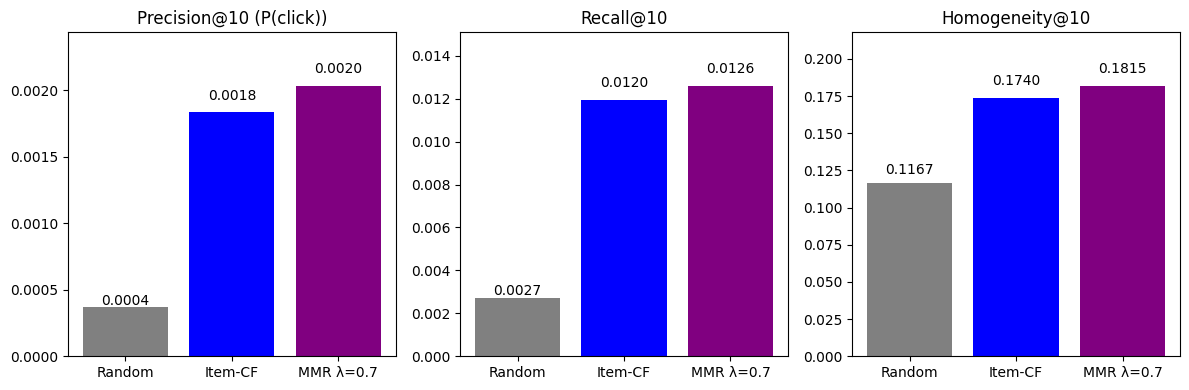

In [14]:
# CELL 17: Simple bar charts @ K = 10 for Accuracy and Homogeneity
import numpy as np

# Filtrar K=10 y reindexar
k10 = comprehensive_results[comprehensive_results['K']==10] \
        .set_index(['Method','Lambda'])

# Extraer métricas clave
methods = ['Random', 'Item-CF', 'MMR λ=0.7']
prec_vals = [
    k10.loc[('Random', np.nan),'Precision'],
    k10.loc[('Item-CF', np.nan),'Precision'],
    k10.loc[('MMR',   0.7),     'Precision']
]
rec_vals = [
    k10.loc[('Random', np.nan),'Recall'],
    k10.loc[('Item-CF', np.nan),'Recall'],
    k10.loc[('MMR',   0.7),     'Recall']
]
homo_vals = [
    k10.loc[('Random', np.nan),'Homogeneity'],
    k10.loc[('Item-CF', np.nan),'Homogeneity'],
    k10.loc[('MMR',   0.7),     'Homogeneity']
]

# Dibujar
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for ax, vals, title in zip(axes, [prec_vals, rec_vals, homo_vals],
                           ['Precision@10 (P(click))','Recall@10','Homogeneity@10']):
    ax.bar(methods, vals, color=['gray','blue','purple'])
    ax.set_title(title)
    ax.set_ylim(0, max(vals)*1.2)
    for i,v in enumerate(vals):
        ax.text(i, v*1.05, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()


In [18]:
# CELL 20: Relevance vs Diversity scatter for K = 10
import matplotlib.pyplot as plt

# Assuming prec_cf, prec_mmr, ils_cf, ils_mmr are defined from your K=10 metrics
methods     = ['Item-CF', 'MMR λ=0.7']
precisions  = [prec_cf, prec_mmr]
ils_values  = [ils_cf, ils_mmr]

plt.figure(figsize=(6,6))
plt.scatter(precisions, ils_values, color=['blue','purple'], s=100)
for method, x, y in zip(methods, precisions, ils_values):
    plt.text(x, y, method, fontsize=12, ha='right', va='bottom')

plt.xlabel('Precision@10 (≈ P(click))')
plt.ylabel('Intra-List Similarity@10')
plt.title('Relevance vs Diversity Trade-Off at K=10')
plt.grid(True)
plt.show()


NameError: name 'prec_cf' is not defined

In [25]:
# CELL 17: Comprehensive Visualization Setup
# -----------------------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Load comprehensive results for plotting
comprehensive_results = pd.read_csv(f"{base_path}/comprehensive_results.csv")
delta_results = pd.read_csv(f"{base_path}/delta_analysis.csv")

print("Creating comprehensive visualizations...")

Creating comprehensive visualizations...


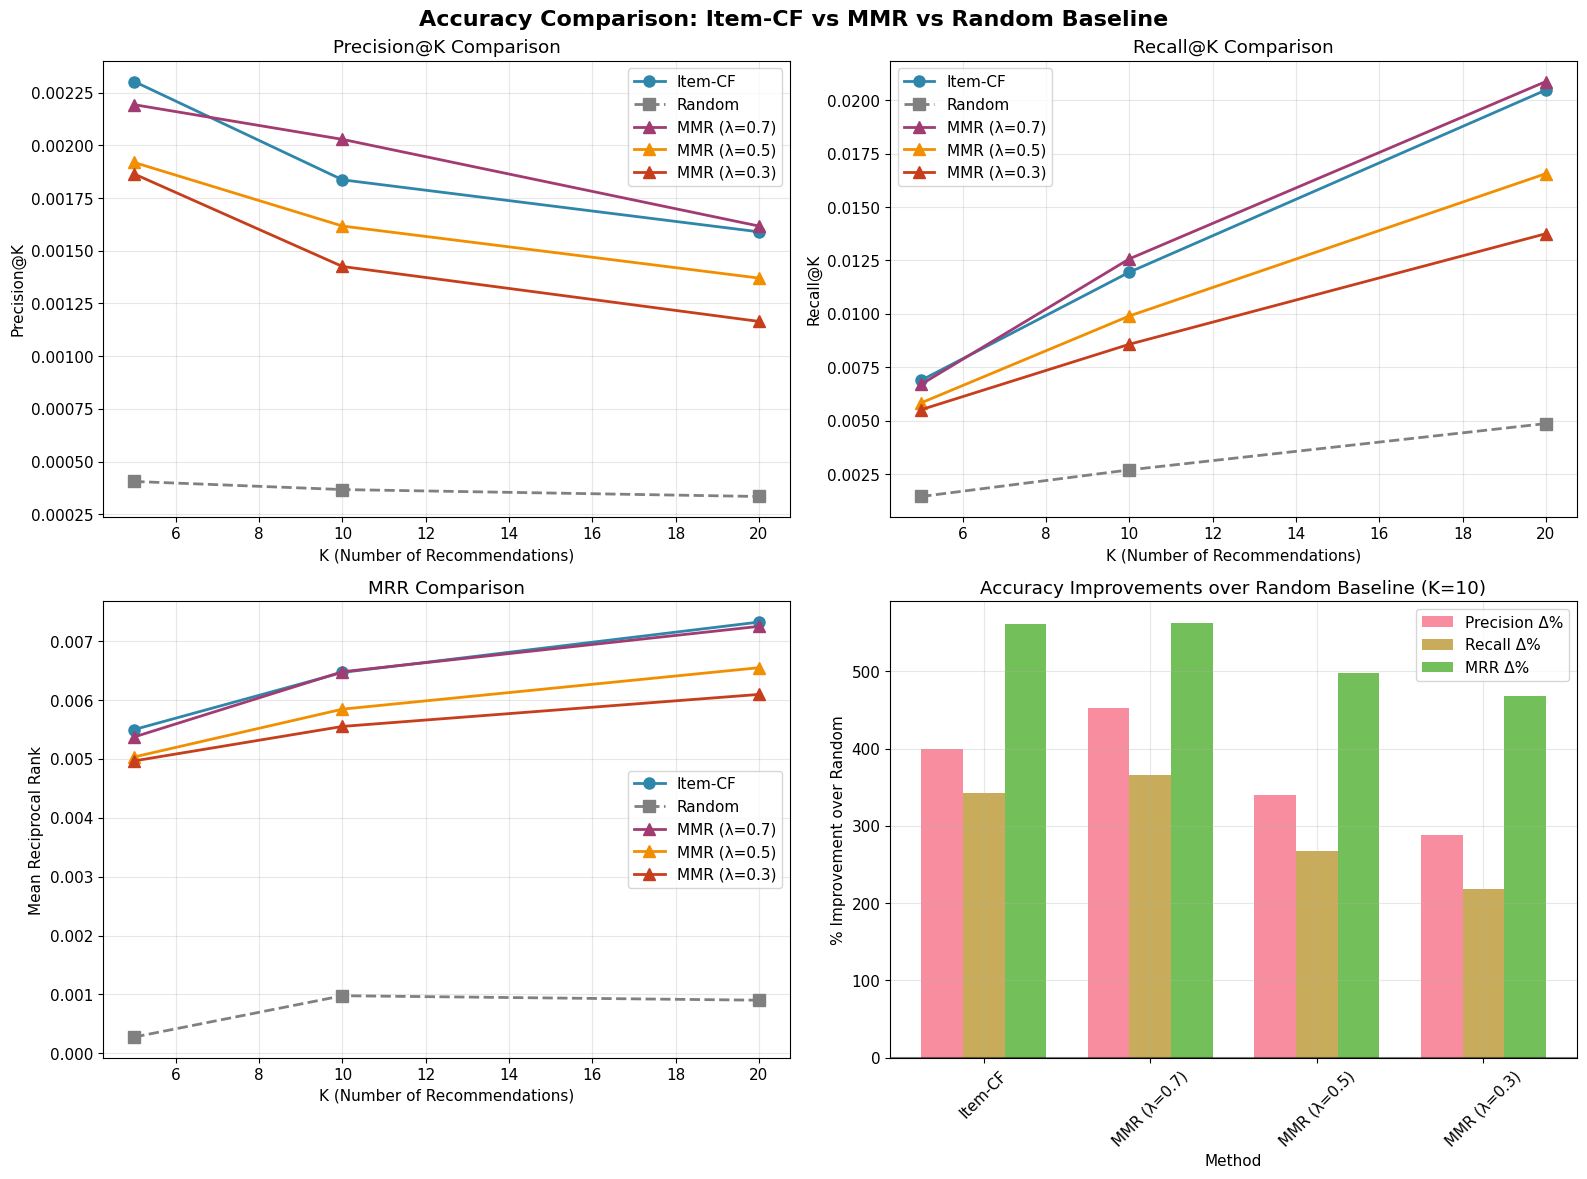

In [27]:
# CELL 18: Accuracy Comparison (Precision, Recall, MRR)
# -----------------------------------------------------------------------------

def plot_accuracy_comparison():
    """
    Creates side-by-side comparison of accuracy metrics for all methods.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Accuracy Comparison: Item-CF vs MMR vs Random Baseline', fontsize=16, fontweight='bold')

    # Prepare data for plotting
    methods_colors = {
        'Item-CF': '#2E86AB',
        'MMR': ['#A23B72', '#F18F01', '#C73E1D'],  # Different colors for different lambdas
        'Random': '#808080'
    }

    K_values = sorted(comprehensive_results['K'].unique())

    # Plot 1: Precision@K
    ax1 = axes[0, 0]
    for method in ['Item-CF', 'Random']:
        data = comprehensive_results[comprehensive_results['Method'] == method]
        if method == 'Item-CF':
            ax1.plot(data['K'], data['Precision'], 'o-', color=methods_colors[method],
                    linewidth=2, markersize=8, label=method)
        else:
            ax1.plot(data['K'], data['Precision'], 's--', color=methods_colors[method],
                    linewidth=2, markersize=8, label=method)

    # MMR with different lambdas
    mmr_data = comprehensive_results[comprehensive_results['Method'] == 'MMR']
    lambda_colors = dict(zip([0.7, 0.5, 0.3], methods_colors['MMR']))
    for i, lambda_val in enumerate([0.7, 0.5, 0.3]):
        lambda_data = mmr_data[mmr_data['Lambda'] == lambda_val]
        ax1.plot(lambda_data['K'], lambda_data['Precision'], '^-',
                color=lambda_colors[lambda_val], linewidth=2, markersize=8,
                label=f'MMR (λ={lambda_val})')

    ax1.set_xlabel('K (Number of Recommendations)')
    ax1.set_ylabel('Precision@K')
    ax1.set_title('Precision@K Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Recall@K
    ax2 = axes[0, 1]
    for method in ['Item-CF', 'Random']:
        data = comprehensive_results[comprehensive_results['Method'] == method]
        if method == 'Item-CF':
            ax2.plot(data['K'], data['Recall'], 'o-', color=methods_colors[method],
                    linewidth=2, markersize=8, label=method)
        else:
            ax2.plot(data['K'], data['Recall'], 's--', color=methods_colors[method],
                    linewidth=2, markersize=8, label=method)

    for i, lambda_val in enumerate([0.7, 0.5, 0.3]):
        lambda_data = mmr_data[mmr_data['Lambda'] == lambda_val]
        ax2.plot(lambda_data['K'], lambda_data['Recall'], '^-',
                color=lambda_colors[lambda_val], linewidth=2, markersize=8,
                label=f'MMR (λ={lambda_val})')

    ax2.set_xlabel('K (Number of Recommendations)')
    ax2.set_ylabel('Recall@K')
    ax2.set_title('Recall@K Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: MRR Comparison
    ax3 = axes[1, 0]
    for method in ['Item-CF', 'Random']:
        data = comprehensive_results[comprehensive_results['Method'] == method]
        if method == 'Item-CF':
            ax3.plot(data['K'], data['MRR'], 'o-', color=methods_colors[method],
                    linewidth=2, markersize=8, label=method)
        else:
            ax3.plot(data['K'], data['MRR'], 's--', color=methods_colors[method],
                    linewidth=2, markersize=8, label=method)

    for i, lambda_val in enumerate([0.7, 0.5, 0.3]):
        lambda_data = mmr_data[mmr_data['Lambda'] == lambda_val]
        ax3.plot(lambda_data['K'], lambda_data['MRR'], '^-',
                color=lambda_colors[lambda_val], linewidth=2, markersize=8,
                label=f'MMR (λ={lambda_val})')

    ax3.set_xlabel('K (Number of Recommendations)')
    ax3.set_ylabel('Mean Reciprocal Rank')
    ax3.set_title('MRR Comparison')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Delta Improvements Bar Chart
    ax4 = axes[1, 1]

    # Create bar chart for K=10 improvements
    k10_deltas = delta_results[delta_results['K'] == 10]
    methods = []
    precision_deltas = []
    recall_deltas = []
    mrr_deltas = []

    for _, row in k10_deltas.iterrows():
        if row['Method'] == 'MMR':
            methods.append(f"MMR (λ={row['Lambda']})")
        else:
            methods.append(row['Method'])
        precision_deltas.append(row['Delta_Precision_%'])
        recall_deltas.append(row['Delta_Recall_%'])
        mrr_deltas.append(row['Delta_MRR_%'])

    x = np.arange(len(methods))
    width = 0.25

    ax4.bar(x - width, precision_deltas, width, label='Precision Δ%', alpha=0.8)
    ax4.bar(x, recall_deltas, width, label='Recall Δ%', alpha=0.8)
    ax4.bar(x + width, mrr_deltas, width, label='MRR Δ%', alpha=0.8)

    ax4.set_xlabel('Method')
    ax4.set_ylabel('% Improvement over Random')
    ax4.set_title('Accuracy Improvements over Random Baseline (K=10)')
    ax4.set_xticks(x)
    ax4.set_xticklabels(methods, rotation=45)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)

    plt.tight_layout()
    plt.savefig(f"{base_path}/accuracy_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

plot_accuracy_comparison()


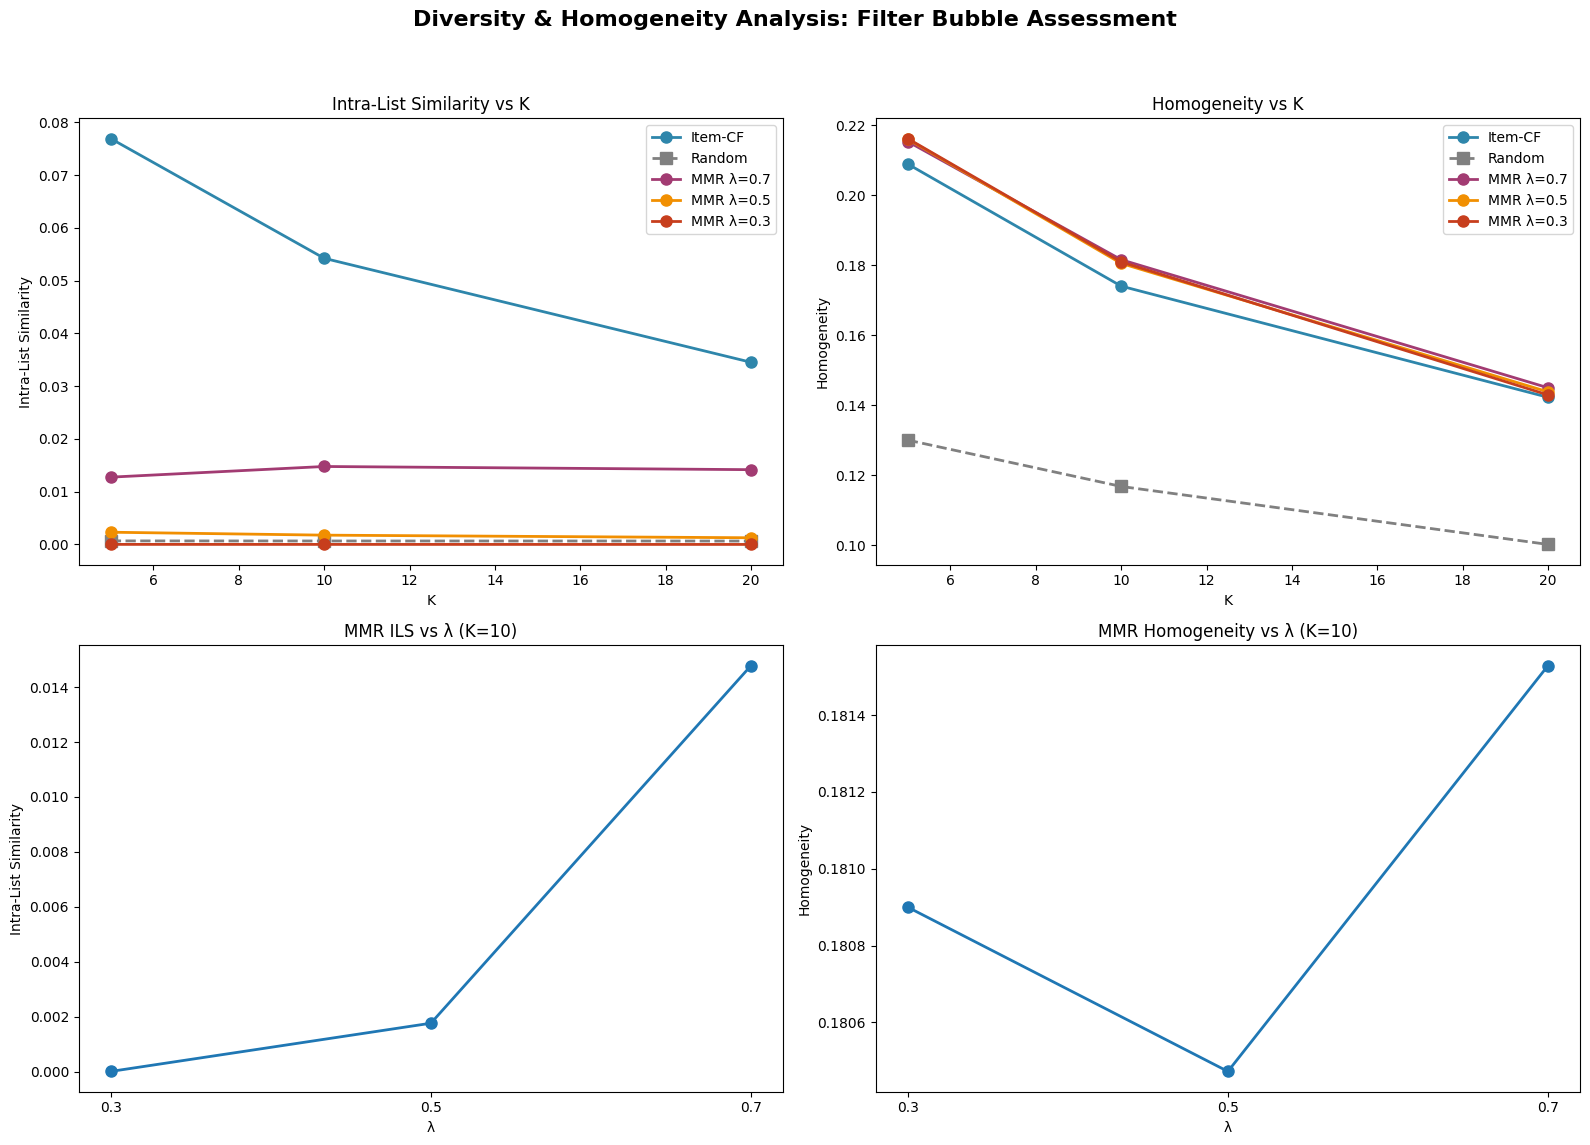

In [13]:
# CELL 19: Diversity and Homogeneity Analysis
# -----------------------------------------------------------------------------

def plot_diversity_homogeneity():
    """
    Creates comprehensive diversity and homogeneity comparison plots.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Diversity & Homogeneity Analysis: Filter Bubble Assessment',
                 fontsize=16, fontweight='bold')

    methods_colors = {
        'Item-CF': '#2E86AB',
        'MMR': ['#A23B72', '#F18F01', '#C73E1D'],
        'Random': '#808080'
    }

    # 1) Intra-List Similarity vs K (lower = more diverse)
    ax1 = axes[0, 0]
    for method in ['Item-CF', 'Random']:
        data = comprehensive_results[comprehensive_results['Method'] == method]
        style = 'o-' if method == 'Item-CF' else 's--'
        ax1.plot(data['K'], data['ILS'], style,
                 color=methods_colors[method],
                 linewidth=2, markersize=8, label=method)

    mmr_data = comprehensive_results[comprehensive_results['Method'] == 'MMR']
    lambda_colors = dict(zip([0.7, 0.5, 0.3], methods_colors['MMR']))
    for lambda_val in [0.7, 0.5, 0.3]:
        lambda_data = mmr_data[mmr_data['Lambda'] == lambda_val]
        ax1.plot(lambda_data['K'], lambda_data['ILS'], 'o-',
                 color=lambda_colors[lambda_val],
                 linewidth=2, markersize=8,
                 label=f'MMR λ={lambda_val}')

    ax1.set_title('Intra-List Similarity vs K')
    ax1.set_xlabel('K')
    ax1.set_ylabel('Intra-List Similarity')
    ax1.legend()


    # 2) Homogeneity vs K (lower = more homogeneous)
    ax2 = axes[0, 1]
    for method in ['Item-CF', 'Random']:
        data = comprehensive_results[comprehensive_results['Method'] == method]
        style = 'o-' if method == 'Item-CF' else 's--'
        ax2.plot(data['K'], data['Homogeneity'], style,
                 color=methods_colors[method],
                 linewidth=2, markersize=8, label=method)

    for lambda_val in [0.7, 0.5, 0.3]:
        lambda_data = mmr_data[mmr_data['Lambda'] == lambda_val]
        ax2.plot(lambda_data['K'], lambda_data['Homogeneity'], 'o-',
                 color=lambda_colors[lambda_val],
                 linewidth=2, markersize=8,
                 label=f'MMR λ={lambda_val}')

    ax2.set_title('Homogeneity vs K')
    ax2.set_xlabel('K')
    ax2.set_ylabel('Homogeneity')
    ax2.legend()


    # Choose a fixed K (e.g., 10) for lambda‐sensitivity plots
    K_fixed = 10
    mmr_k = mmr_data[mmr_data['K'] == K_fixed]
    lambdas = sorted(mmr_k['Lambda'].unique())

    # 3) MMR Intra-List Similarity vs Lambda at K_fixed
    ax3 = axes[1, 0]
    ils_vals = [mmr_k[mmr_k['Lambda'] == lam]['ILS'].values[0] for lam in lambdas]
    ax3.plot(lambdas, ils_vals, 'o-', linewidth=2, markersize=8)
    ax3.set_title(f'MMR ILS vs λ (K={K_fixed})')
    ax3.set_xlabel('λ')
    ax3.set_ylabel('Intra-List Similarity')
    ax3.set_xticks(lambdas)

    # 4) MMR Homogeneity vs Lambda at K_fixed
    ax4 = axes[1, 1]
    hom_vals = [mmr_k[mmr_k['Lambda'] == lam]['Homogeneity'].values[0] for lam in lambdas]
    ax4.plot(lambdas, hom_vals, 'o-', linewidth=2, markersize=8)
    ax4.set_title(f'MMR Homogeneity vs λ (K={K_fixed})')
    ax4.set_xlabel('λ')
    ax4.set_ylabel('Homogeneity')
    ax4.set_xticks(lambdas)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# ¡Llama a la función al final de la celda!
plot_diversity_homogeneity()



In [10]:
# Asegúrate de que el DataFrame comprehensive_results esté cargado
# Si no lo está, ejecuta la celda 15 o cárgalo desde el archivo:
# comprehensive_results = pd.read_csv(f"{base_path}/comprehensive_results.csv")

print("\nTabla Resumen de Resultados Clave (K=10)")
print("="*60)

# Filtrar resultados para K=10
results_k10 = comprehensive_results[comprehensive_results['K'] == 10].copy()

# Renombrar columnas para que sean más descriptivas en la presentación
results_k10 = results_k10.rename(columns={
    'Precision': 'Prec@10',
    'Recall': 'Rec@10',
    'MRR': 'MRR',
    'ILS': 'ILS@10', # ILS es Intra-List Similarity, no Intra-List Diversity. Mayor ILS = menos diversidad.
    'Homogeneity': 'Homogeneity@10',
    'Lambda': 'MMR Lambda' # Para distinguir los MMR con diferentes lambdas
})

# Seleccionar y ordenar las columnas que quieres mostrar
# Considera agregar Entropy si también quieres mostrar una métrica de diversidad
summary_table = results_k10[['Method', 'MMR Lambda', 'Prec@10', 'Rec@10', 'MRR', 'ILS@10', 'Homogeneity@10']]

# Formatear los valores para mostrar solo 4 decimales
for col in ['Prec@10', 'Rec@10', 'MRR', 'ILS@10', 'Homogeneity@10']:
    if col in summary_table.columns:
        summary_table[col] = summary_table[col].map('{:.4f}'.format)

# Manejar el valor de 'MMR Lambda' para los métodos sin lambda
summary_table['MMR Lambda'] = summary_table['MMR Lambda'].fillna('-')

# Ordenar para una mejor visualización (por método y luego por lambda)
summary_table = summary_table.sort_values(by=['Method', 'MMR Lambda'])

# Imprimir la tabla
display(summary_table) # Usa display para una mejor visualización en Colab/Jupyter


Tabla Resumen de Resultados Clave (K=10)


<ipython-input-10-dfcf793a7935>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_table[col] = summary_table[col].map('{:.4f}'.format)
<ipython-input-10-dfcf793a7935>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_table['MMR Lambda'] = summary_table['MMR Lambda'].fillna('-')


,Method,MMR Lambda,Prec@10,Rec@10,MRR,ILS@10,Homogeneity@10
1,Item-CF,-,0.0018,0.0120,0.0065,0.0543,0.1740
8,MMR,0.3,0.0014,0.0086,0.0056,0.0000,0.1809
7,MMR,0.5,0.0016,0.0099,0.0058,0.0018,0.1805
6,MMR,0.7,0.0020,0.0126,0.0065,0.0148,0.1815
13,Random,-,0.0004,0.0027,0.0010,0.0007,0.1167
